# Image blending

This notebook is for showing the concept of blending methods and doing comparison. For the project, we use the poisson blending.

Be sure to create a file named "custom_data" and put your images in.

For the main part, please check the ece278a_final.ipynb

## Helper function

### Automatic masking and shift

PART 1:
1. click ‘p’ to enter polygon mode this will allow you to select a polygon by clicking various points
2. when done selecting the polygon click ‘q’ which will fill in the mask on the image
3. then click some point in the center that will be used to align the mask with the second image
4. hit escape when done
5. the state of the image can be reset by hitting ‘r’ note that you will need to hit ‘p’ again to enter polygon mode
6. click ‘o’ or ‘i’ to rotate the image
7. click ‘=‘ or ‘-‘ to resize the image

PART 2:
1. click anywhere in the image to overlay mask
2. hit escape when done to save masks
3. click r at anytime to reset frame

PART 3:
1. masks are stored with the same name + “_mask.png” in the same folder as the code
2. new source image is stored with name + “_newsource.png”

source: https://github.com/nikhilushinde/cs194-26_proj3_2.2

In [ ]:
# Nikhil Uday Shinde: 7/23/18
# https://github.com/nikhilushinde/cs194-26_proj3_2.2

import cv2
import numpy as np
import skimage as sk
import skimage.io as skio
from skimage import img_as_ubyte
# global variables for drawing on mask
from skimage.transform import SimilarityTransform, warp
from PIL import Image

drawing = False
polygon = False
centerMode = False
contours = []
polygon_center = None
img = None

def create_mask(imname):
    masks_to_ret = {"centers":[], "contours":[], "offsets":[]}

    global drawing, polygon, contours, centerMode, polygon_center
    pressed_key = 0
    # mouse callback function
    def draw_circle(event,x,y,flags,param):
        global drawing, centerMode, polygon, pressed_key
        if drawing == True and event == cv2.EVENT_MOUSEMOVE:
            cv2.circle(img,(x,y),10,(255,255,255),-1)
            cv2.circle(mask,(x,y),10,(255,255,255),-1)
        if polygon == True and event == cv2.EVENT_LBUTTONDOWN:
            contours.append([x,y])
            cv2.circle(img,(x,y),2,(255,255,255),-1)
        if centerMode == True and event == cv2.EVENT_LBUTTONDOWN:
            polygon_center = (x,y)
            print(polygon_center)
            cv2.circle(img, polygon_center, 3, (255, 0, 0), -1)
            centerMode = False

            masks_to_ret["centers"].append(polygon_center)
            masks_to_ret["contours"].append(contours)

    # Create a black image, a window and bind the function to window
    orig_img = cv2.imread(imname)
    reset_orig_img = orig_img[:]
    mask = np.zeros(orig_img.shape, np.uint8)
    img = np.array(orig_img[:])
    cv2.namedWindow('image')

    cv2.setMouseCallback('image',draw_circle)

    angle = 0
    delta_angle = 5
    resize_factor = 1.1
    total_resize = 1
    adjusted = False

    while(1):
        cv2.imshow('image',img)
        pressed_key = cv2.waitKey(20) & 0xFF

        """
        Commands:
        d: toggle drawing mode
        p: toggle polygon mode
        q: draw polygon once selected, and select center
        """

        if pressed_key == 27:
            break
        elif pressed_key == ord('d'):
            drawing = not drawing
            print("drawing status: ", drawing)
        elif pressed_key == ord('p'):
            polygon = not polygon
            print("polygon status: ", polygon)
        elif polygon == True and pressed_key == ord('q') and len(contours) > 2:
            contours = np.array(contours)
            cv2.fillPoly(img, pts=[contours], color = (255,255,255))
            cv2.fillPoly(mask, pts=[contours], color = (255,255,255))

            centerMode = True
            polygon = False
        elif pressed_key == ord('o'):
            # loop over the rotation angles again, this time ensuring
            # no part of the image is cut off
            angle = (angle + delta_angle) % 360
            adjusted = True
            print("Rotate")

        elif pressed_key == ord('i'):
            # loop over the rotation angles again, this time ensuring
            # no part of the image is cut off
            angle = (angle - delta_angle) % 360  
            adjusted = True
            print("Rotate")
        
        # Plus
        elif pressed_key == ord('='):
            total_resize = total_resize*resize_factor
            adjusted = True
            print("Resize up")

        # Minus
        elif pressed_key == ord('-'):
            total_resize = total_resize*(1/resize_factor)
            adjusted = True
            print("Resize down")
        

        elif pressed_key == ord('r'):
            img = np.array(reset_orig_img)
            contours = []
            masks_to_ret["centers"] = []
            masks_to_ret["contours"] = []

            centerMode = False
            polygon = False
            angle = 0
            total_resize = 1

            print("polygon status: False")

        # adjust
        if adjusted:
            rows,cols,_ = orig_img.shape
            M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
            img = cv2.resize(orig_img, dsize=(0,0), fx=total_resize, fy=total_resize)
            img = cv2.warpAffine(img,M,(cols,rows))
            cv2.imshow('image', img)
            adjusted = False
            

    cv2.destroyAllWindows()
    name = imname.split('/')[-1]

    # store offsets to allow recreation of masks in target image
    for center_num in range(len(masks_to_ret["centers"])):
        offset = []
        center = masks_to_ret["centers"][center_num]
        for point in masks_to_ret["contours"][center_num]:
            xoffset = point[0] - center[0]
            yoffset = point[1] - center[1]

            offset.append([xoffset, yoffset])
        masks_to_ret["offsets"].append(offset)

    # adjust the output image
    rows,cols,_ = orig_img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    adj_orig_img = cv2.resize(reset_orig_img, dsize=(0,0), fx=total_resize, fy=total_resize)
    adj_orig_img = cv2.warpAffine(adj_orig_img,M,(cols,rows))
    # print('masks_to_ret', masks_to_ret)
    # print('adj_orig_img', adj_orig_img.shape)
    return masks_to_ret, adj_orig_img

def paste_mask(im2name, masks_to_ret, im2=None):
    im2masks_to_ret = {"centers":[], "contours":[]}

    # mouse callback function
    def draw_circle(event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN:
            centernew = [x,y]
            new_contour = []
            for offsets in masks_to_ret["offsets"]:
                for point in offsets:
                    xnew = point[0] + centernew[0]
                    ynew = point[1] + centernew[1]
                    new_contour.append([xnew, ynew])
            new_contour= np.array(new_contour)
            print(new_contour)
            im2masks_to_ret["centers"].append(centernew)
            im2masks_to_ret["contours"].append(new_contour)

            cv2.fillPoly(img, pts=[new_contour], color = (255,255,255))

    # Create a black image, a window and bind the function to window
    if type(im2) == type(None):
        orig_img = cv2.imread(im2name)#np.zeros((512,512,3), np.uint8)
    else:
        orig_img = np.array(im2)

    img = np.array(orig_img[:])
    cv2.namedWindow('image')
    cv2.resizeWindow('image', 600,600)
    cv2.setMouseCallback('image',draw_circle)

    while(1):
        cv2.imshow('image',img)
        pressed_key = cv2.waitKey(20) & 0xFF

        if pressed_key == 27:
            break 
        if pressed_key == ord('r'):
            img = np.array(orig_img)
            im2masks_to_ret["centers"] = []
            im2masks_to_ret["contours"] = []
    cv2.destroyAllWindows()
    print("im2masks_to_ret", im2masks_to_ret)
    print("orig_img", orig_img.shape)
    return im2masks_to_ret, orig_img

# run with 2 image names to generate and save masks and new source image
def save_masks(im1name, im2name):
    masks_to_ret, source_im = create_mask(im1name)
    im2masks_to_ret, target_im = paste_mask(im2name=im2name, masks_to_ret=masks_to_ret)
    # im1 is the source, im2 is the target
    source_mask = np.zeros((source_im.shape[0], source_im.shape[1], 3))
    target_mask = np.zeros((target_im.shape[0], target_im.shape[1], 3))
    cv2.fillPoly(source_mask, np.array([masks_to_ret["contours"][0]]), (255,255,255))
    cv2.fillPoly(target_mask, np.array([im2masks_to_ret["contours"][0]]), (255,255,255))

    name1 = im1name.split('/')[-1]
    name1 = name1[:-4]

    name2 = im2name.split('/')[-1]
    name2 = name2[:-4]

    source_mask = np.clip(sk.img_as_float(source_mask), -1, 1)
    target_mask = np.clip(sk.img_as_float(target_mask), -1, 1)
    source_im = np.clip(sk.img_as_float(source_im), -1, 1)
    source_im = np.dstack([source_im[:,:,2], source_im[:,:,1], source_im[:,:,0]])

    offset =  np.array(-im2masks_to_ret['contours'][0][0]) + np.array(masks_to_ret['contours'][0][0])
    print(offset)
    
    tform = SimilarityTransform(translation=offset)
    warped = warp(source_im, tform, output_shape=target_im.shape)
    # print(name1 + "_mask.png")
    
    source_mask = (source_mask - source_mask.min()) / (source_mask.max() - source_mask.min()) * 255
    target_mask = (target_mask - target_mask.min()) / (target_mask.max() - target_mask.min()) * 255
    warped = (warped - warped.min()) / (warped.max() - warped.min()) * 255
    source_mask = source_mask.astype(np.uint8)
    target_mask = target_mask.astype(np.uint8)
    warped = warped.astype(np.uint8)
    source_mask = Image.fromarray(source_mask)
    target_mask = Image.fromarray(target_mask)
    warped = Image.fromarray(warped)
    
    source_mask.save("./custom_data/" + name1 + "_mask.jpg")
    target_mask.save("./custom_data/" + name2 + "_mask.jpg")
    warped.save("./custom_data/" + name1 + "_newsource.jpg")    
    
    return source_mask, target_mask, warped

### Display

In [ ]:
def display_images(images, titles):
    """Helper function to display images in a grid."""
    n = len(images)
    plt.figure(figsize=(20, 10))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        
        plt.imshow(cv.cvtColor(images[i].astype('float32'), cv.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

## Multi-band(Pyramid) blending 

### Method: Gaussian and Laplacian stacks

In [ ]:
def gaussian_pyramid(image, level):
    img = image.copy()
    #img = img/255
    g_pyramid = [img]
    for index in range(level):
        sigma = 2**index
        
        blurred = cv.GaussianBlur(g_pyramid[index], None, sigmaX = sigma)
        g_pyramid.append(blurred)
    return g_pyramid

def laplacian_pyramid(image, level):
    
    g_pyramid = gaussian_pyramid(image, level)
    la_pyramid = []
    for index in range(level):
        previous = index
        now = index+1
        one_level = g_pyramid[previous] - g_pyramid[now]
        la_pyramid.append(one_level)
    la_pyramid.append(g_pyramid[level])
    return la_pyramid

### Pyramid Blending

In [ ]:
def pyramid_blend(img1, img2, mask, levels):
    img1_lapyramid = laplacian_pyramid(img1, levels)
    img2_lapyramid = laplacian_pyramid(img2, levels)
    mask_gpyramid = gaussian_pyramid(mask, levels)
    reconstr = []
    for i in range(levels+1):
        reconstr_level = (mask_gpyramid[i]) * img1_lapyramid[i] + (1-mask_gpyramid[i]) * img2_lapyramid[i]
        reconstr.append(reconstr_level)
    blend = sum(reconstr)
    return blend

### Example:

In [ ]:
import cv2 as cv
from matplotlib.pyplot import figure
import scipy
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp

In [ ]:
im1name = "yourimage1.jpg"  # resource for blending
im2name = "yourimage2.jpg"  # background image
name1 = im1name.split('/')[-1]
name1 = name1[:-4]
name2 = im2name.split('/')[-1]
name2 = name2[:-4]

img1 = cv.imread("custom_data/" + name1 + ".jpg")
img2 = cv.imread("custom_data/" + name2 + ".jpg")
img1 = cv.resize(img1, (512,512))
img2 = cv.resize(img2, (512,512))
cv.imwrite("custom_data/" + name1 + ".jpg",img1)
cv.imwrite("custom_data/" + name2 + ".jpg",img2)

In [ ]:
img1 = cv.imread("custom_data/" + name1 + ".jpg")
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.show()
img1.shape

In [ ]:
img2 = cv.imread("custom_data/" + name2 + ".jpg")
plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
plt.show()
img2.shape

In [ ]:
im1name = "custom_data/" + name1 + ".jpg"
im2name = "custom_data/" + name2 + ".jpg"
source_mask, target_mask, warped = save_masks(im1name, im2name)

In [ ]:
warped = cv.imread("custom_data/" + name1 + "_newsource.jpg")
target = cv.imread("custom_data/" + name2 + ".jpg")
warped = np.array((warped/255.), dtype = 'float32')
target = np.array((target/255.), dtype = 'float32')

In [ ]:
warped_gpyramid = gaussian_pyramid(warped, 5)
warped_lapyramid = laplacian_pyramid(warped, 5)

In [ ]:
# Display Gaussian pyramid
display_images(warped_gpyramid, [f'Gaussian Level {i}' for i in range(len(warped_gpyramid))])

# Display Laplacian pyramid
display_images(warped_lapyramid, [f'Laplacian Level {i}' for i in range(len(warped_lapyramid))])

In [ ]:
target_gpyramid = gaussian_pyramid(target, 5)
target_lapyramid = laplacian_pyramid(target, 5)

In [ ]:
# Display Gaussian pyramid
display_images(target_gpyramid, [f'Gaussian Level {i}' for i in range(len(target_gpyramid))])

# Display Laplacian pyramid
display_images(target_lapyramid, [f'Laplacian Level {i}' for i in range(len(target_lapyramid))])

In [ ]:
target_mask = cv.imread("custom_data/" + name2 + "_mask.jpg")
_, binary_mask = cv.threshold(target_mask, 127, 255, cv.THRESH_BINARY)
target_mask = np.where(binary_mask == 255, 1, 0)
plt.imshow(target_mask[:,:,0])
target_mask = np.reshape(target_mask.astype('float32'), (512,512,3))
target_mask[100,400]

In [ ]:
target_mask_gpyramid = gaussian_pyramid(target_mask, 5)
target_mask_lapyramid = laplacian_pyramid(target_mask, 5)

In [ ]:
# Display Gaussian pyramid
display_images(target_mask_gpyramid, [f'Gaussian Level {i}' for i in range(len(target_mask_gpyramid))])

In [ ]:
pyramid_result = pyramid_blend(warped,target, target_mask, 5)

In [ ]:
figure(figsize = (20,10))
naive = warped*target_mask + target*(1-target_mask)
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(naive, cv.COLOR_BGR2RGB))
cv.imwrite("custom_data/result/naive/" + name1 + "_" + name2 + "_" + "naive.jpg",naive*255)

plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(pyramid_result, cv.COLOR_BGR2RGB))
cv.imwrite("custom_data/result/pyramid/" + name1 + "_" + name2 + "_" + "pyramid.jpg",pyramid_result*255)
plt.show()

In [ ]:
figure(figsize = (20,10))
plt.subplot(1,3,1)
plt.imshow(cv.cvtColor(target, cv.COLOR_BGR2RGB))
plt.subplot(1,3,2)
plt.imshow(cv.cvtColor(warped, cv.COLOR_BGR2RGB))
plt.subplot(1,3,3)
plt.imshow(cv.cvtColor(pyramid_result, cv.COLOR_BGR2RGB))

## Poisson Blending

In [ ]:
import cv2 as cv
from PIL import Image
from matplotlib.pyplot import figure
import scipy
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp

In [ ]:
img1 = cv.imread("custom_data/" + name1 + ".jpg")
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))

img2 = cv.imread("custom_data/" + name2 + ".jpg")
plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
plt.show()
print(img1.shape)
print(img2.shape)

### Poisson function

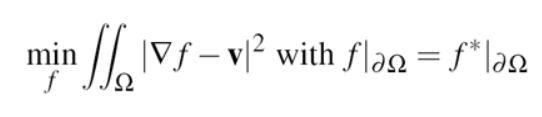

In [ ]:
def poisson_blend(fg, mask, bg, mixed=False):
    """
    Poisson Blending
    fg: (H, W, C) source texture / foreground object
    mask: (H, W, 1)
    bg: (H, W, C) target image / background
    return: (H, W, C)
    """
    imh, imw, channels = min(fg.shape, bg.shape)
    n_pixels = imh * imw
    im2var = np.arange(n_pixels).reshape((imh, imw)).astype(int)
    v_rgb = np.empty((imh, imw, channels), dtype=int)
    A = sp.lil_matrix((n_pixels, n_pixels))
    mask_index = np.where(mask == True)
    n_mask = len(mask_index[0])

    for c in range(channels):
        b = np.zeros((n_pixels, 1))
        for index in range(n_mask):
            y = mask_index[0][index]
            x = mask_index[1][index]
            e = (y - 1) * imw + x
            # construct A, only construct once because A is same for 3 channels
            if c == 0:
                if (y - 1) >= 0:
                    if mask[y - 1, x]:
                        A[e, im2var[y - 1, x]] = -1
                if (y + 1) <= mask.shape[0] - 1:
                    if mask[y + 1, x]:
                        A[e, im2var[y + 1, x]] = -1
                if (x - 1) >= 0:
                    if mask[y, x - 1]:
                        A[e, im2var[y, x - 1]] = -1
                if (x + 1) <= mask.shape[1] - 1:
                    if mask[y, x + 1]:
                        A[e, im2var[y, x + 1]] = -1
                # center point is 4
                A[e, im2var[y, x]] = 4

            # construct b, construct 3 times because b is different for r, g, b
            # check the border
            if y - 1 < 0:
                fg_up = fg[y, x, c]
                bg_up = 0
            else:
                fg_up = fg[y - 1, x, c]
                bg_up = bg[y - 1, x, c]
            if y + 1 > mask.shape[0] - 1:
                fg_down = fg[y, x, c]
                bg_down = 0
            else:
                fg_down = fg[y + 1, x, c]
                bg_down = bg[y + 1, x, c]
            if x - 1 < 0:
                fg_left = fg[y, x, c]
                bg_left = 0
            else:
                fg_left = fg[y, x - 1, c]
                bg_left = bg[y, x - 1, c]
            if x + 1 > mask.shape[1] - 1:
                fg_right = fg[y, x, c]
                bg_right = 0
            else:
                fg_right = fg[y, x + 1, c]
                bg_right = bg[y, x + 1, c]

            if mixed:
                # mixed gradients
                s1 = fg[y, x, c] - fg_up
                t1 = bg[y, x, c] - bg_up
                s2 = fg[y, x, c] - fg_down
                t2 = bg[y, x, c] - bg_down
                s3 = fg[y, x, c] - fg_left
                t3 = bg[y, x, c] - bg_left
                s4 = fg[y, x, c] - fg_right
                t4 = bg[y, x, c] - bg_right

                b[e] = 0
                b[e] += s1 if abs(s1) > abs(t1) else t1
                b[e] += s2 if abs(s2) > abs(t2) else t2
                b[e] += s3 if abs(s3) > abs(t3) else t3
                b[e] += s4 if abs(s4) > abs(t4) else t4
            else:
                b[e] = 4 * fg[y, x, c] - fg_up - fg_down - fg_right - fg_left
                

            if y - 1 >= 0:
                if not mask[y - 1, x]:
                    b[e] += bg_up
            if y + 1 <= mask.shape[0] - 1:
                if not mask[y + 1, x]:
                    b[e] += bg_down
            if x - 1 >= 0:
                if not mask[y, x - 1]:
                    b[e] += bg_left
            if x + 1 <= mask.shape[1] - 1:
                if not mask[y, x + 1]:
                    b[e] += bg_right

        # calculate lsq, only the mask area is what we want
        v = scipy.sparse.linalg.lsqr(A.tocsr(), b)[0] * 255
        v_rgb[:, :, c] = v.reshape((imh, imw)).astype(int)

    return v_rgb / 255. , mask, bg 

### Run blending (poisson only)

In [ ]:
def runblending(name1, name2, transparency):
    """
    Run Poisson Blending
    name1: 'str' filename of foreground object 
    name2: 'str' filename of background
    return: (H, W, 3) the blended image in BGR format
    """
    im1name = "custom_data/" + name1 + ".jpg"
    im2name = "custom_data/" + name2 + ".jpg"
    source_mask, target_mask, warped = save_masks(im1name, im2name)
    
    target_mask = cv.imread("custom_data/" + name2 + "_mask.jpg")
    _, binary_mask = cv.threshold(target_mask[:,:,0], 127, 255, cv.THRESH_BINARY)
    target_mask = np.where(binary_mask == 255, 1, 0)
    target_mask = np.reshape(target_mask, (512,512,1))

    warped = cv.imread("custom_data/" +name1 + "_newsource.jpg")
    target = cv.imread("custom_data/" + name2 + ".jpg")
    warped = (warped/255.)
    target = (target/255.)
    res, mask, bg = poisson_blend(warped, target_mask, target, mixed = transparency)
    result = (1-mask)*bg + (mask) * res
    return result.astype('float32')

### Run blending (after doing pyramid blending)

In [ ]:
def runblending(name1, name2,transparency):
    """
    Run Poisson Blending
    name1: 'str' filename of foreground object 
    name2: 'str' filename of background
    return: (H, W, 3) the blended image in BGR format
    """

    target_mask = cv.imread("custom_data/" + name2 + "_mask.jpg")
    _, binary_mask = cv.threshold(target_mask[:,:,0], 127, 255, cv.THRESH_BINARY)
    target_mask = np.where(binary_mask == 255, 1, 0)
    target_mask = np.reshape(target_mask, (512,512,1))

    warped = cv.imread("custom_data/" +name1 + "_newsource.jpg")
    target = cv.imread("custom_data/" + name2 + ".jpg")
    warped = (warped/255.)
    target = (target/255.)
    res, mask, bg = poisson_blend(warped, target_mask, target, mixed = transparency)
    result = (1-mask)*bg + (mask) * res
    return result.astype('float32')

In [ ]:
result = runblending(name1, name2, 0)

### Display results

In [ ]:
cv.namedWindow('image')
cv.imshow('image', result)
cv.waitKey(0)
cv.destroyAllWindows()

### Fail Examples

Harsh on the border condition
1. background is complicated
2. background is not matched

In [ ]:
figure(figsize = (20,15))

name1, name2 = ("castle", "summitsky")
naive = cv.imread("custom_data/result/naive/" + name1 + "_" + name2 + "_" + "naive.jpg")
naive = cv.cvtColor(naive, cv.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(naive)

poisson = cv.imread("custom_data/result/poisson/" + name1 + "_" + name2 + "_" + "poisson.jpg")
poisson = cv.cvtColor(poisson, cv.COLOR_BGR2RGB)
plt.subplot(1,2,2)
plt.imshow(poisson)
plt.show()

### Comparison

In [ ]:
target_mask = cv.imread("custom_data/" + name2 + "_mask.jpg")
_, binary_mask = cv.threshold(target_mask[:,:,0], 127, 255, cv.THRESH_BINARY)
target_mask = np.where(binary_mask == 255, 1, 0)
target_mask = np.reshape(target_mask, (512,512,1))
target_mask.shape

mask = target_mask
warped = cv.imread("custom_data/" +name1 + "_newsource.jpg")
bg = cv.imread("custom_data/" + name2 + ".jpg")
warped = (warped/255.)
bg = (bg/255.)

In [ ]:
poisson = cv.imread("custom_data/result/poisson/" + name1 + "_" + name2 + "_" + "poisson.jpg")
pyramid_result = cv.imread("custom_data/result/pyramid/" + name1 + "_" + name2 + "_" + "pyramid.jpg")

In [ ]:
figure(figsize = (20,15))

naive = ((1-mask)*bg + (mask) * warped).astype('float32')
#cv.imwrite("custom_data/result/naive/" + name1 + "_" + name2 + "_" + "naive.jpg",naive*255)
naive = cv.cvtColor(naive, cv.COLOR_BGR2RGB)
plt.subplot(1,3,1)
plt.title('Naive')
plt.imshow(naive)

#poisson = result.astype('float32')
#cv.imwrite("custom_data/result/poisson/" + name1 + "_" + name2 + "_" + "poisson.jpg",poisson*255)
poisson = cv.cvtColor(poisson, cv.COLOR_BGR2RGB)
plt.subplot(1,3,2)
plt.title('Poisson Blending')
plt.imshow(poisson)


plt.subplot(1,3,3)
plt.title('Pyramid Blending')
plt.imshow(cv.cvtColor(pyramid_result, cv.COLOR_BGR2RGB))
#cv.imwrite("custom_data/result/pyramid/" + name1 + "_" + name2 + "_" + "pyramid.jpg",pyramid_result*255)
plt.show()

## Conclusion

Pyramid blending

pros:
1. Much faster
2. Not restricted to the background

Cons:
1. Need to be windowed well to get a good result
2. Does not get a good blending when the color is very different with the background

Poisson blending

pros:
1. Have a more natural-looking and seamless result

Cons:
1. Takes lots of time for approximation
2. Be prone to a bad result when encounters a mismatched border
3. Might accumulate noise(black in the middle) when the croping area is too large 